# Source Sink Algorithm Validation Algorithm - Interictal Data



In [1]:
%load_ext lab_black

In [3]:
import numpy as np
import scipy
import scipy.io
import pandas as pd
from pathlib import Path
import os
import collections
from natsort import natsorted
import json

from sklearn.preprocessing import OrdinalEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    brier_score_loss,
    roc_curve,
    average_precision_score,
    roc_auc_score,
    f1_score,
    balanced_accuracy_score,
    accuracy_score,
    auc,
    plot_precision_recall_curve,
    average_precision_score,
    precision_recall_curve,
)
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, cross_validate
from sklearn.utils import resample

from mne_bids import BIDSPath, get_entities_from_fname, get_entity_vals
from rerf.rerfClassifier import rerfClassifier

from oblique_forests.sporf import ObliqueForestClassifier

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
class MatReader:
    """
    Object to read mat files into a nested dictionary if need be.
    Helps keep strucutre from matlab similar to what is used in python.
    """

    def __init__(self, filename=None):
        self.filename = filename

    def loadmat(self, filename):
        """
        this function should be called instead of direct spio.loadmat
        as it cures the problem of not properly recovering python dictionaries
        from mat files. It calls the function check keys to cure all entries
        which are still mat-objects
        """
        try:
            data = scipy.io.loadmat(
                filename, struct_as_record=False, squeeze_me=True, chars_as_strings=True
            )
        except NotImplementedError as e:
            print(e)
            data = hdf5storage.loadmat(filename)
        return self._check_keys(data)

    def _check_keys(self, dict):
        """
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        """
        for key in dict:
            if isinstance(dict[key], scipy.io.matlab.mio5_params.mat_struct):
                dict[key] = self._todict(dict[key])
        return dict

    def _todict(self, matobj):
        """
        A recursive function which constructs from matobjects nested dictionaries
        """
        dict = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, scipy.io.matlab.mio5_params.mat_struct):
                dict[strg] = self._todict(elem)
            elif isinstance(elem, np.ndarray):
                dict[strg] = self._tolist(elem)
            else:
                dict[strg] = elem
        return dict

    def _tolist(self, ndarray):
        """
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        """
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, scipy.io.matlab.mio5_params.mat_struct):
                elem_list.append(self._todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(self._tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list

# Setup Data Directory

In [5]:
root = Path("/Users/adam2392/Dropbox/epilepsy_interictal")
root = Path("/home/adam2392/hdd/Dropbox/epilepsy_interictal")
deriv_root = root / "derivatives"
source_root = root / "sourcedata"

session = "presurgery"
task = "interictal"
acquisition = "seeg"  # note not all subjects are actually sEEG
reference = "car"
deriv_chain = Path("sourcesink") / reference / "remove_artifact_wins"

deriv_path = deriv_root / deriv_chain

In [6]:
meta_fpath = source_root / "ieeg_database_all.xlsx"

In [7]:
subjects = natsorted(get_entity_vals(deriv_path, "subject"))
print(subjects)

['002', '003', '004', '005', '006', '009', '011', '013', '014', '015', 'NIH1', 'NIH2', 'NIH3', 'NIH4', 'NIH5', 'NIH7', 'NIH8', 'NIH9', 'NIH10', 'NIH11', 'PY18N002', 'PY18N013', 'PY18N015', 'PY19N012', 'PY19N015', 'PY19N023', 'PY19N026', 'la01', 'la02', 'la03', 'la04', 'la05', 'la06', 'la07', 'la08', 'la09', 'la10', 'la11', 'la13', 'la15', 'la16', 'la21', 'la22', 'la23', 'la24', 'nl01', 'nl02', 'nl04', 'nl05', 'nl06', 'nl07', 'nl08', 'nl11', 'nl12', 'nl13', 'nl14', 'nl15', 'nl16', 'nl18', 'nl19', 'nl20', 'pt1', 'pt2', 'pt3', 'pt4', 'pt5', 'pt6', 'pt7', 'pt8', 'pt9', 'pt10', 'pt11', 'pt12', 'pt13']


## Obtain Labels Using Excel Sheet

In [8]:
meta_df = pd.read_excel(meta_fpath)

display(meta_df.head(2))

,org_patientid,patient_id,number_datasets,clinical_center,modality,sfreq,previous_surgery?,clinical_complexity,engel_score,ilae_score,...,mri_outcome,postop_progress_info,date_of_recording,date_of_surgery,date_of_last_follow_up,years_follow_up,engel_class_full,notes,Unnamed: 38,Unnamed: 39
0,NaN,la01,1,cc,seeg,1000,"Y (SEEG implant 4/2013, craniotomy 4/2013)",4,4.0,4.0,...,Normal,Seizure free since surgery.,2013-04-10 02:11:44,2014-01-01 00:00:00,2019-10-01 00:00:00,5,NaN,NaN,NaN,NaN
1,NaN,la02,1,cc,seeg,1000,VNS implant 4/24/2014,1,1.0,1.0,...,Normal,Seizure free since surgery.,NaN,2015-02-01 00:00:00,2018-11-01 00:00:00,3,NaN,PPT says: Lesion?,NaN,NaN


# Obtain Source Sink Data From Each File

In [9]:
dataset = collections.defaultdict(list)

for subject in subjects:
    subj_dir = deriv_path / f"sub-{subject}"
    fpaths = subj_dir.glob("*.mat")
    for idx, fpath in enumerate(fpaths):
        data_path = BIDSPath(
            subject=subject,
            session=session,
            task=task,
            acquisition=acquisition,
            run=idx + 1,
            suffix="ss_ind",
            extension=".mat",
            check=False,
        )
        print(f"Reading {fpath}")
        reader = MatReader()
        data_dict = reader.loadmat(fpath)

        #         print(data_dict.keys())
        ch_names = data_dict["labels"]
        soz_chs = data_dict["ez_ch"]
        sink_ind = np.array(data_dict["sink_index"])
        source_infl = np.array(data_dict["source_infl"])
        sink_conn = data_dict["sink_conn"]
        ss_ind = data_dict["ss_index"]

        dataset["subject"].append(subject)
        dataset["sink_ind"].append(sink_ind)
        dataset["source_infl"].append(source_infl)
        dataset["sink_conn"].append(sink_conn)
        dataset["ss_ind"].append(ss_ind)
        dataset["ch_names"].append(ch_names)
        dataset["soz_chs"].append(soz_chs)

#         break

#     break

Reading /home/adam2392/hdd/Dropbox/epilepsy_interictal/derivatives/sourcesink/car/remove_artifact_wins/sub-002/sub-002_ses-presurgery_task-interictal_acq-seeg_run-01_ss_ind.mat
Reading /home/adam2392/hdd/Dropbox/epilepsy_interictal/derivatives/sourcesink/car/remove_artifact_wins/sub-003/sub-003_ses-presurgery_task-interictal_acq-seeg_run-01_ss_ind.mat
Reading /home/adam2392/hdd/Dropbox/epilepsy_interictal/derivatives/sourcesink/car/remove_artifact_wins/sub-004/sub-004_ses-presurgery_task-interictal_acq-seeg_run-01_ss_ind.mat
Reading /home/adam2392/hdd/Dropbox/epilepsy_interictal/derivatives/sourcesink/car/remove_artifact_wins/sub-005/sub-005_ses-presurgery_task-interictal_acq-seeg_run-01_ss_ind.mat
Reading /home/adam2392/hdd/Dropbox/epilepsy_interictal/derivatives/sourcesink/car/remove_artifact_wins/sub-006/sub-006_ses-presurgery_task-interictal_acq-seeg_run-01_ss_ind.mat
Reading /home/adam2392/hdd/Dropbox/epilepsy_interictal/derivatives/sourcesink/car/remove_artifact_wins/sub-009/sub-

## Stratify Source Sink Heatmaps Into Two Sets of Data

In [10]:
def plot_subject_feature_map(dataset, desired_subject, feature_name):
    for idx, subject in enumerate(dataset["subject"]):
        # get the index of the subject
        if subject != desired_subject:
            continue

        # get the metadata
        soz_chs = dataset["soz_chs"][idx]
        ch_names = dataset["ch_names"][idx]
        soz_inds = [idx for idx, ch in enumerate(ch_names) if ch in soz_chs]
        nsoz_inds = [idx for idx in range(len(ch_names)) if idx not in soz_inds]

        # get the data
        feature_map = dataset[feature_name][idx]

        # stratify data into two sets of signals
        soz_feat = feature_map[soz_inds, :]
        nsoz_feat = feature_map[nsoz_inds, :]

        x = np.arange(soz_feat.shape[1])

        sns.set_context("paper", font_scale=1.75)
        fig, ax = plt.subplots()
        #     plt.tick_params(labelsize=14)
        y_mean = soz_feat.mean(axis=0)
        y_sem = scipy.stats.sem(soz_feat, axis=0)
        ax.plot(x, y_mean, label="soz", color="red")
        ax.fill_between(x, y_mean - y_sem, y_mean + y_sem, color="red", alpha=0.5)

        y_mean = nsoz_feat.mean(axis=0)
        y_sem = scipy.stats.sem(nsoz_feat, axis=0)
        ax.plot(x, y_mean, label="soz^c", color="black")
        ax.fill_between(x, y_mean - y_sem, y_mean + y_sem, color="black", alpha=0.5)

        ax.set(
            title=f"Subject {subject} - {feature_name}",
            xlabel="Time (A.U.)",
            ylabel=f"{feature_name} Value",
            #         font_size=20,
        )
        ax.legend()
        break

# Disc

Hypothesis: All indices should be higher in SOZ vs SOZ^C.

source_infl, sink_conn, sink_ind all from A matrix, but not directly from each other
ss_ind = source_infl * sink_conn * sink_ind

Exps:
- source_infl -> quantile vectors -> RF -> cv
- sink_conn -> ''
- sink_ind -> ''
- source_infl, sink_conn, sink_ind -> quantile vectors -> RF -> cv
- ^ repeat the above 4, but instead take E[A] first, and the average A -> source_infl (vector) -> quantile

Note: ss_ind = combination of all three, so no need to add

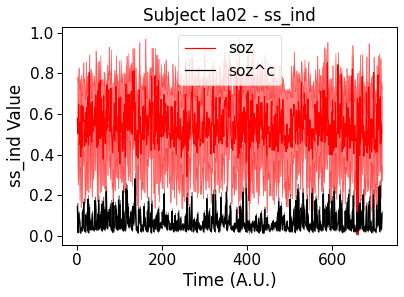

In [11]:
desired_subject = "la02"
feature_name = "ss_ind"

plot_subject_feature_map(dataset, desired_subject, feature_name)

In [12]:
# create X, y pair for training
X = []
y = []
engels = []
ilaes = []
subjects = []

for idx, subject in enumerate(dataset["subject"]):
    # get the metadata
    soz_chs = dataset["soz_chs"][idx]
    ch_names = dataset["ch_names"][idx]
    soz_inds = [idx for idx, ch in enumerate(ch_names) if ch in soz_chs]
    nsoz_inds = [idx for idx in range(len(ch_names)) if idx not in soz_inds]

    # get the data
    feature_map = dataset[feature_name][idx]

    # stratify data into two sets of signals
    soz_feat = feature_map[soz_inds, :]
    nsoz_feat = feature_map[nsoz_inds, :]

    # compute quantiles in each
    qtiles = np.linspace(0.1, 1.0, 10)

    # create a time-varying quantile heatmap
    soz_quant_map = np.vstack([np.quantile(soz_feat, q=q, axis=0) for q in qtiles])
    nsoz_quant_map = np.vstack([np.quantile(nsoz_feat, q=q, axis=0) for q in qtiles])
    new_data_feat = np.vstack(
        (
            np.mean(soz_feat, axis=0),
            np.std(soz_feat, axis=0),
            soz_quant_map,
            np.mean(nsoz_feat, axis=0),
            np.std(nsoz_feat, axis=0),
            nsoz_quant_map,
        )
    )
    #     sns.heatmap(new_data_feat)
    new_data_feat = np.mean(new_data_feat, axis=1, keepdims=True)
    #     plt.figure()
    #     sns.heatmap(new_data_feat)

    # get metadata
    outcome = meta_df[meta_df["patient_id"] == subject]["outcome"].values[0]
    engel = meta_df[meta_df["patient_id"] == subject]["engel_score"].values[0]
    ilae = meta_df[meta_df["patient_id"] == subject]["ilae_score"].values[0]

    if outcome == "NR":
        continue

    X.append(new_data_feat)

    y.append(outcome)
    engels.append(engel)
    ilaes.append(ilae)
    subjects.append(subject)

#     print(soz_quant_map.shape, nsoz_quant_map.shape)
#     print(new_data_feat.shape)
#     break

In [13]:
from sklearn import preprocessing

enc = preprocessing.OrdinalEncoder()

In [14]:
X = np.array(X).squeeze()
y = np.array(y).squeeze()

y = enc.fit_transform(y[:, np.newaxis]).squeeze()
print(X.shape)
print(y.shape)
print(y)

(71, 24)
(71,)
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1.]


# Run Classification Validation Pipeline

In [17]:
n_splits = 10
train_size = 0.5
random_state = 12345

subject_groups = subjects

In [18]:
cv = GroupShuffleSplit(
    n_splits=n_splits, train_size=train_size, random_state=random_state
)

In [22]:
n_features = X.shape[1]
model_params = {
    #     "projection_matrix": "RerF",
    "n_estimators": 500,
    "max_features": n_features,
    "n_jobs": -1,
    "random_state": random_state,
}
# clf = rerfClassifier(**model_params)

clf = ObliqueForestClassifier(**model_params)

In [23]:
print(X.shape, X_test.shape)

(71, 24) (36, 24)


In [26]:
cv_scores = collections.defaultdict(list)

for jdx, (train_inds, test_inds) in enumerate(cv.split(X, y, subject_groups)):

    # perform CV using Sklearn
    scoring_funcs = {
        "roc_auc": roc_auc_score,
        "accuracy": accuracy_score,
        "balanced_accuracy": balanced_accuracy_score,
        "average_precision": average_precision_score,
        "precision": "",
        "neg_brier_score": brier_score_loss,
        "recall": "",
        "f1": "",
    }

    # run cross-validation
    scores = cross_validate(
        clf,
        X,
        y,
        groups=subject_groups,
        cv=cv,
        scoring=list(scoring_funcs.keys()),
        return_estimator=True,
        return_train_score=True,
        n_jobs=1,
    )

    # removing array like structure
    scores = {key: val[0] for key, val in scores.items()}
    estimator = scores.pop("estimator")

    print("Using estimator ", estimator)

    # evaluate on the test set
    y_test = y[test_inds]
    X_test = X[test_inds, :]
    y_pred_prob = estimator.predict_proba(X_test)[:, 1]

    # compute calibration curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test, y_pred_prob, n_bins=10, strategy="quantile"
    )
    scores["test_fraction_pos"] = []

    scores["test_fraction_pos"] = list(fraction_of_positives)
    scores["test_mean_pred_value"] = list(mean_predicted_value)

    # store ROC curve metrics on the held-out test set
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
    fnr, tnr, neg_thresholds = roc_curve(y_test, y_pred_prob, pos_label=0)
    scores["test_fpr"] = list(fpr)
    scores["test_tpr"] = list(tpr)
    scores["test_fnr"] = list(fnr)
    scores["test_tnr"] = list(tnr)
    scores["test_thresholds"] = list(thresholds)

    # store per cross validation
    cv_scores[jdx] = scores

    break

Using estimator  ObliqueForestClassifier(max_features=24, n_estimators=500, n_jobs=-1,
                        random_state=12345)


In [27]:
print(scores.keys())

dict_keys(['fit_time', 'score_time', 'test_roc_auc', 'train_roc_auc', 'test_accuracy', 'train_accuracy', 'test_balanced_accuracy', 'train_balanced_accuracy', 'test_average_precision', 'train_average_precision', 'test_precision', 'train_precision', 'test_neg_brier_score', 'train_neg_brier_score', 'test_recall', 'train_recall', 'test_f1', 'train_f1', 'test_fraction_pos', 'test_mean_pred_value', 'test_fpr', 'test_tpr', 'test_fnr', 'test_tnr', 'test_thresholds'])


In [ ]:
fname = deriv_root / f"cv{n_splits}_exp_{feature_name}"

In [36]:
with open(fname, "w") as file_name:
    json.dump(cv_scores, file_name)